<center>
<img src="../../img/ods_stickers.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Authors: [Maria Sumarokova](https://www.linkedin.com/in/mariya-sumarokova-230b4054/), and [Yury Kashnitsky](https://www.linkedin.com/in/festline/). Translated and edited by Gleb Filatov, Aleksey Kiselev, [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #3 (demo)
## <center>  Decision trees with a toy task and the UCI Adult dataset 

Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution). Fill in the answers in the [web-form](https://docs.google.com/forms/d/1wfWYYoqXTkZNOPy1wpewACXaj2MZjBdLOL58htGWYBA/edit).

Let's start by loading all necessary libraries:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
import collections
from io import StringIO

import numpy as np
import pandas as pd
import pydotplus  # pip install pydotplus
import seaborn as sns
from ipywidgets import Image
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz

### Part 1. Toy dataset "Will They? Won't They?"

Your goal is to figure out how decision trees work by walking through a toy problem. While a single decision tree does not yield outstanding results, other performant algorithms like gradient boosting and random forests are based on the same idea. That is why knowing how decision trees work might be useful.

We'll go through a toy example of binary classification - Person A is deciding whether they will go on a second date with Person B. It will depend on their looks, eloquence, alcohol consumption (only for example), and how much money was spent on the first date.

#### Creating the dataset

In [2]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

#### Training data

In [4]:
df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)
df_train


,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


#### Test data

In [5]:
df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [6]:
df_train.shape, df_test.shape

((7, 10), (3, 8))

In [7]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train["Will_go"]
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Money_spent_lots,Alcoholic_beverage_no,Money_spent_little,Alcoholic_beverage_yes,Eloquence_high,Looks_handsome,Eloquence_average,Looks_repulsive
0,1,0,0,1,1,1,0,0
1,0,0,1,1,0,1,0,0
2,1,1,0,0,0,1,1,0
3,0,1,1,0,0,0,1,1
4,1,0,0,1,0,0,0,1
5,1,0,0,1,1,0,0,1
6,1,0,0,1,0,1,1,0


In [8]:
df_test

,Money_spent_lots,Alcoholic_beverage_no,Money_spent_little,Alcoholic_beverage_yes,Eloquence_high,Looks_handsome,Eloquence_average,Looks_repulsive
0,1,1,0,0,0,1,1,0
1,0,0,1,1,1,1,0,0
2,1,0,0,1,0,0,1,1


In [9]:
df_train.shape, df_test.shape

((7, 8), (3, 8))

#### Draw a decision tree (by hand or in any graphics editor) for this dataset. Optionally you can also implement tree construction and draw it here.

1\. What is the entropy $S_0$ of the initial system? By system states, we mean values of the binary feature "Will_go" - 0 or 1 - two states in total.

In [10]:
# you code here

In [11]:
y.value_counts()

0    4
1    3
Name: Will_go, dtype: int64

In [12]:
from scipy.stats import entropy

In [13]:
base = 2
p_k = np.array([4/7, 3/7])
s0 = entropy(p_k, base=base)
print(f' S0 = {s0}')

 S0 = 0.9852281360342515


2\. Let's split the data by the feature "Looks_handsome". What is the entropy $S_1$ of the left group - the one with "Looks_handsome". What is the entropy $S_2$ in the opposite group? What is the information gain (IG) if we consider such a split?

In [14]:
# you code here

In [15]:
df_tr = pd.concat([df_train, y], axis=1)
df_tr

,Money_spent_lots,Alcoholic_beverage_no,Money_spent_little,Alcoholic_beverage_yes,Eloquence_high,Looks_handsome,Eloquence_average,Looks_repulsive,Will_go
0,1,0,0,1,1,1,0,0,0
1,0,0,1,1,0,1,0,0,1
2,1,1,0,0,0,1,1,0,0
3,0,1,1,0,0,0,1,1,1
4,1,0,0,1,0,0,0,1,1
5,1,0,0,1,1,0,0,1,0
6,1,0,0,1,0,1,1,0,0


In [16]:
pd.crosstab(df_tr['Looks_handsome'], df_tr['Will_go'])

Will_go,0,1
Looks_handsome,,
0,1,2
1,3,1


In [17]:
base = 2
p_k = np.array([4/7, 3/7])
print(f'entropy = {entropy(p_k, base=base)}')

entropy = 0.9852281360342515


In [18]:
s1 = entropy([3/4, 1/4], base=base)
s2 = entropy([1/3, 2/3], base=base) 
print(f's1 = {s1}, s2 = {s2}')

s1 = 0.8112781244591328, s2 = 0.9182958340544894


In [19]:
ig = s0 - (4 / 7) * s1 - (3 / 7) * s2
print(f'ig = {ig}')

ig = 0.12808527889139443


#### Train a decision tree using sklearn on the training data. You may choose any depth for the tree.

In [20]:
# you code here

In [21]:
simple_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
simple_tree.fit(df_train, y)

DecisionTreeClassifier(max_depth=3, random_state=17)

#### Additional: display the resulting tree using graphviz. You can use pydot or [web-service](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.

In [22]:
# you code here

In [23]:
from sklearn import tree

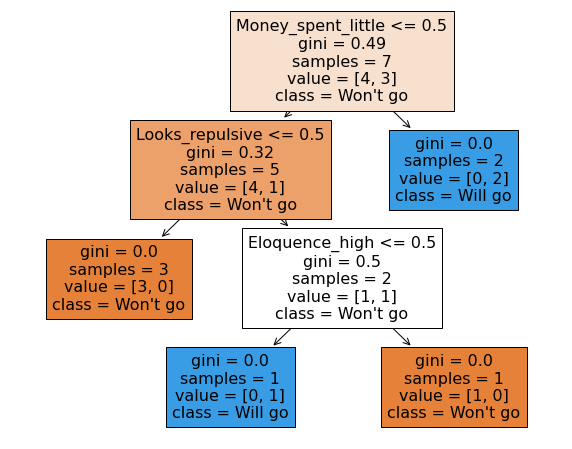

In [24]:
tree.plot_tree(
    simple_tree, feature_names=df_train.columns, filled=True, class_names=["Won't go", "Will go"]
);

### Part 2. Functions for calculating entropy and information gain.

Consider the following warm-up example: we have 9 blue balls and 11 yellow balls. Let ball have label **1** if it is blue, **0** otherwise.

In [25]:
balls = [1 for i in range(9)] + [0 for i in range(11)]
balls

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

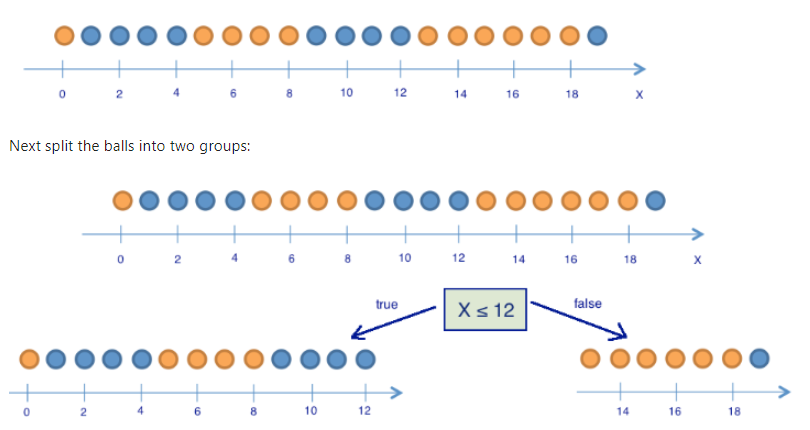

In [26]:
# two groups
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

#### Implement a function to calculate the Shannon Entropy

In [27]:
import math
def entropy_(a_list):
    # you code here
    _, count_list = np.unique(np.array(a_list), return_counts=True)
    n = sum(count_list)
    p_list = [x / n for x in count_list]
    s = sum((- p_k * math.log2(p_k) for p_k in p_list))
    return s

Tests

In [28]:
print(entropy_(balls))  # 9 blue и 11 yellow
print(entropy_(balls_left))  # 8 blue и 5 yellow
print(entropy_(balls_right))  # 1 blue и 6 yellow
print(entropy_([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die

0.9927744539878084
0.961236604722876
0.5916727785823275
2.584962500721156


3\. What is the entropy of the state given by the list **balls_left**?

**Ответ:** entropy = 0.961

4\. What is the entropy of a fair dice? (where we look at a dice as a system with 6 equally probable states)?

In [29]:
print(f'entropy = {entropy_(range(1, 7))}') 

entropy = 2.584962500721156


**Ответ:** entropy = 2.58

In [30]:
# information gain calculation
def information_gain(root, left, right):
    """ root - initial data, left and right - two partitions of initial data"""
    # you code here
    entropy_root = entropy_(root)
    _left = entropy_(left) * len(left)
    _right = entropy_(right) * len(right)
    len_root = len(root)
    return entropy_root - (_left + _right)/len_root
    


5\. What is the information gain from splitting the initial dataset into **balls_left** and **balls_right** ?

In [31]:
print(f'ig = {information_gain(balls, balls_left, balls_right)}')

ig = 0.16088518841412436


In [32]:
def information_gains(X, y):
    """Outputs information gain when splitting with each feature"""
    # you code here
    out = [information_gain(y, y[X[column] == 0], y[X[column] == 1]) for column in X.columns]
    return out

In [33]:
information_gains(df_train, y)

[0.46956521111470717,
 0.0059777114237740125,
 0.46956521111470717,
 0.0059777114237740125,
 0.2916919971380597,
 0.12808527889139454,
 0.02024420715375619,
 0.12808527889139454]

#### Optional:
- Implement a decision tree building algorithm by calling `information_gains` recursively
- Plot the resulting tree

In [34]:
def simpl_tree(X, y):
    ig = information_gains(X, y)
    best_feat_ind = ig.index(max(ig))
    best_feat_name = X.columns[best_feat_ind]

    x_left = X[X.loc[:, best_feat_name] == 0]
    x_right = X[X.loc[:, best_feat_name] == 1]
    
    y_left = y[X.loc[:, best_feat_name] == 0]
    y_right = y[X.loc[:, best_feat_name] == 1]
    
    print(f'Best feature to split: {best_feat_name}')
    print(f"Samples: {len(y_left)} (left) and {len(y_right)} (right)")
    
    entropy_left = entropy_(y_left)
    entropy_right = entropy_(y_right)
    print(f"Entropy: {entropy_left} (left) and {entropy_right} (right)")
    print("_" * 30 + "\n")
    
    if entropy_left != 0:
        print(f"Splitting the left group with {len(x_left)} samples:")
        simpl_tree(x_left, y_left)
    if entropy_right != 0:
        print(f"Splitting the right group with {len(x_right)} samples:")
        simpl_tree(x_right, y_right)

In [35]:
simpl_tree(df_train, y)

Best feature to split: Money_spent_lots
Samples: 2 (left) and 5 (right)
Entropy: 0.0 (left) and 0.7219280948873623 (right)
______________________________

Splitting the right group with 5 samples:
Best feature to split: Looks_handsome
Samples: 2 (left) and 3 (right)
Entropy: 1.0 (left) and 0.0 (right)
______________________________

Splitting the left group with 2 samples:
Best feature to split: Eloquence_high
Samples: 1 (left) and 1 (right)
Entropy: 0.0 (left) and 0.0 (right)
______________________________



### Part 3. The "Adult" dataset

#### Dataset description:

[Dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) UCI Adult (no need to download it, we have a copy in the course repository): classify people using demographical data - whether they earn more than \$50,000 per year or not.

Feature descriptions:

- **Age** – continuous feature
- **Workclass** –  continuous feature
- **fnlwgt** – final weight of object, continuous feature
- **Education** –  categorical feature
- **Education_Num** – number of years of education, continuous feature
- **Martial_Status** –  categorical feature
- **Occupation** –  categorical feature
- **Relationship** – categorical feature
- **Race** – categorical feature
- **Sex** – categorical feature
- **Capital_Gain** – continuous feature
- **Capital_Loss** – continuous feature
- **Hours_per_week** – continuous feature
- **Country** – categorical feature

**Target** – earnings level, categorical (binary) feature.

#### Reading train and test data

In [36]:
data_train = pd.read_csv("../data/adult_train.csv", sep=";")

In [37]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [38]:
data_test = pd.read_csv("../data/adult_test.csv", sep=";")

In [39]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [40]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16282 entries, 0 to 16281
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             16282 non-null  object 
 1   Workclass       15318 non-null  object 
 2   fnlwgt          16281 non-null  float64
 3   Education       16281 non-null  object 
 4   Education_Num   16281 non-null  float64
 5   Martial_Status  16281 non-null  object 
 6   Occupation      15315 non-null  object 
 7   Relationship    16281 non-null  object 
 8   Race            16281 non-null  object 
 9   Sex             16281 non-null  object 
 10  Capital_Gain    16281 non-null  float64
 11  Capital_Loss    16281 non-null  float64
 12  Hours_per_week  16281 non-null  float64
 13  Country         16007 non-null  object 
 14  Target          16281 non-null  object 
dtypes: float64(5), object(10)
memory usage: 1.9+ MB


In [41]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[
    (data_test["Target"] == " >50K.") | (data_test["Target"] == " <=50K.")
]

# encode target variable as integer
data_train.loc[data_train["Target"] == " <=50K", "Target"] = 0
data_train.loc[data_train["Target"] == " >50K", "Target"] = 1

data_test.loc[data_test["Target"] == " <=50K.", "Target"] = 0
data_test.loc[data_test["Target"] == " >50K.", "Target"] = 1
data_test

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
5,18,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,0
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,0
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,0
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,0


#### Primary data analysis

In [42]:
data_test.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
data_train["Target"].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

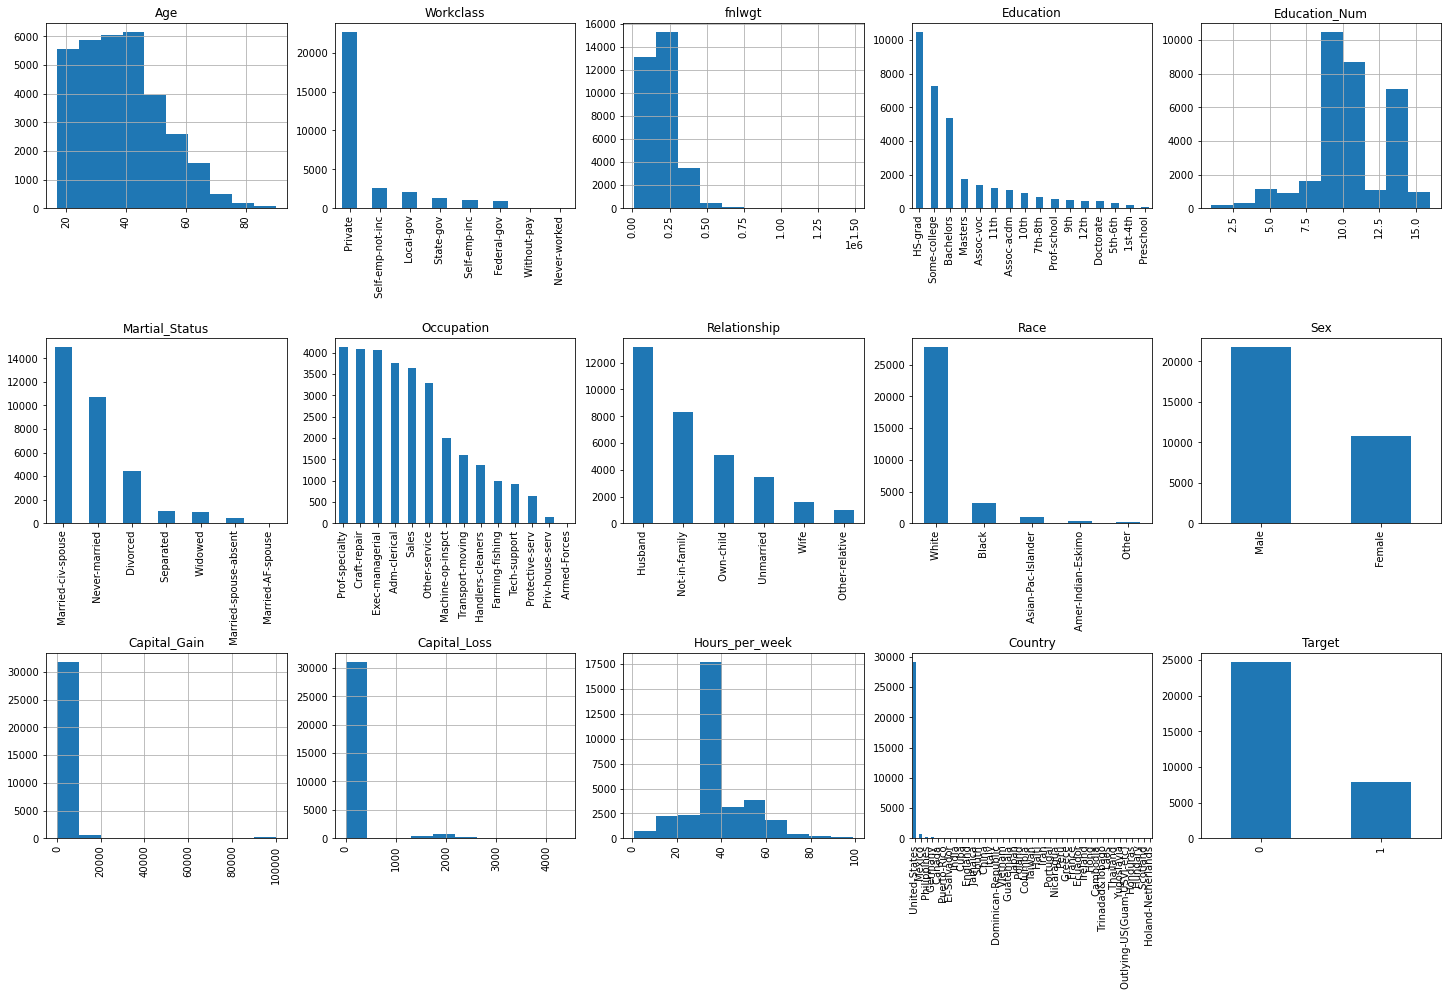

In [44]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(int(rows), cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

#### Checking data types

In [45]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [46]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

As we see, in the test data, age is treated as type **object**. We need to fix this.

In [47]:
data_test["Age"] = data_test["Age"].astype(int)

Also we'll cast all **float** features to **int** type to keep types consistent between our train and test data.

In [48]:
data_test["fnlwgt"] = data_test["fnlwgt"].astype(int)
data_test["Education_Num"] = data_test["Education_Num"].astype(int)
data_test["Capital_Gain"] = data_test["Capital_Gain"].astype(int)
data_test["Capital_Loss"] = data_test["Capital_Loss"].astype(int)
data_test["Hours_per_week"] = data_test["Hours_per_week"].astype(int)

In [49]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [50]:
data_test.dtypes 

Age                int32
Workclass         object
fnlwgt             int32
Education         object
Education_Num      int32
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int32
Capital_Loss       int32
Hours_per_week     int32
Country           object
Target            object
dtype: object

#### Fill in missing data for continuous features with their median values, for categorical features with their mode.

In [51]:
# choose categorical and continuous features from data

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print(f'categorical_columns: {categorical_columns}')
print(f'numerical_columns: {numerical_columns}')

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [52]:
# we see some missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [53]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [54]:
# no more missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  Target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


We'll dummy code some categorical features: **Workclass**, **Education**, **Martial_Status**, **Occupation**, **Relationship**, **Race**, **Sex**, **Country**. It can be done via pandas method **get_dummies**

In [55]:
data_train = pd.concat(
    [data_train[numerical_columns], pd.get_dummies(data_train[categorical_columns])],
    axis=1,
)

data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)

In [56]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Columns: 106 entries, Age to Country_ Yugoslavia
dtypes: int64(7), uint8(99)
memory usage: 4.8 MB


In [57]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [58]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

#### There is no Holland in the test data. Create new zero-valued feature.

In [59]:
data_test["Country_ Holand-Netherlands"] = 0

In [60]:
set(data_train.columns) - set(data_test.columns)

set()

In [61]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [62]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [63]:
X_train = data_train.drop(["Target"], axis=1)
y_train = data_train["Target"]

X_test = data_test.drop(["Target"], axis=1)
y_test = data_test["Target"]

### 3.1 Decision tree without parameter tuning

Train a decision tree **(DecisionTreeClassifier)** with a maximum depth of 3, and evaluate the accuracy metric on the test data. Use parameter **random_state = 17** for results reproducibility.

In [64]:
# you code here
# tree =
# tree.fit

In [65]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

Make a prediction with the trained model on the test data.

In [66]:
# you code here
# tree_predictions = tree.predict

In [67]:
X_test = X_test[X_train.columns]
tree_predictions = tree.predict(X_test)

In [68]:
# you code here
# accuracy_score

6\. What is the test set accuracy of a decision tree with maximum tree depth of 3 and **random_state = 17**?

In [69]:
print(f' depth = 3, accuracy = {accuracy_score(tree_predictions, y_test)}')

 depth = 3, accuracy = 0.8447884036607088


### 3.2 Decision tree with parameter tuning

Train a decision tree **(DecisionTreeClassifier, random_state = 17).** Find the optimal maximum depth using 5-fold cross-validation **(GridSearchCV)**.

In [70]:
# tree_params = {"max_depth": range(2, 11)}

# locally_best_tree = GridSearchCV  # you code here

# locally_best_tree.fit
# # you code here

In [71]:
tree_params = {"max_depth": range(2, 11)}

# locally_best_tree = GridSearchCV()
locally_best_tree = GridSearchCV(tree, tree_params,
            cv=5, n_jobs=-1,
            verbose=1)
locally_best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=17),
             n_jobs=-1, param_grid={'max_depth': range(2, 11)}, verbose=1)

Train a decision tree with maximum depth of 9 (it is the best **max_depth** in my case), and compute the test set accuracy. Use parameter **random_state = 17** for reproducibility.

In [72]:
# you code here
# tuned_tree =
# tuned_tree.fit
# tuned_tree_predictions = tuned_tree.predict
# accuracy_score

In [73]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
print(f' depth = 9, accuracy = {accuracy_score(tuned_tree_predictions, y_test)}')

 depth = 9, accuracy = 0.8579939807137154


7\. What is the test set accuracy of a decision tree with maximum depth of 9 and **random_state = 17**?

**Ответ:** accuracy = 0.85

### 3.3 (Optional) Random forest without parameter tuning

Let's take a sneak peek of upcoming lectures and try to use a random forest for our task. For now, you can imagine a random forest as a bunch of decision trees, trained on slightly different subsets of the training data.

Train a random forest **(RandomForestClassifier)**. Set the number of trees to 100 and use **random_state = 17**.

In [74]:
# you code here
# rf =
# rf.fit # you code here

In [75]:
rf = RandomForestClassifier(random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

Make predictions for the test data and assess accuracy.

In [76]:
# you code here

In [77]:
rf_predictions = rf.predict(X_test)
print(f'Random Forest accuracy = {accuracy_score(y_test, rf_predictions)}')

Random Forest accuracy = 0.8525274860266568


### 3.4 (Optional) Random forest with parameter tuning

Train a random forest **(RandomForestClassifier)**. Tune the maximum depth and maximum number of features for each tree using **GridSearchCV**. 

In [78]:
# forest_params = {'max_depth': range(10, 21),
#                 'max_features': range(5, 105, 20)}

# locally_best_forest = GridSearchCV # you code here

# locally_best_forest.fit # you code here

In [79]:
forest_params = {'max_depth': range(10, 21),
                'max_features': range(5, 105, 20)}

locally_best_forest = GridSearchCV(
            RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=17),
            forest_params, 
            cv=3, n_jobs=-1,
            verbose=1)

locally_best_forest.fit(X_train, y_train)

Fitting 3 folds for each of 55 candidates, totalling 165 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=10, n_jobs=-1,
                                              random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(10, 21),
                         'max_features': range(5, 105, 20)},
             verbose=1)

In [80]:
# tree_params = {"max_depth": range(2, 11)}

# # locally_best_tree = GridSearchCV()
# locally_best_tree = GridSearchCV(tree, tree_params,
#             cv=5, n_jobs=-1,
#             verbose=True)
# locally_best_tree.fit(X_train, y_train)
# # you code here

Make predictions for the test data and assess accuracy.

In [81]:
# you code here

In [82]:
tuned_rf_predictions = locally_best_forest.predict(X_test)
print(f'locally_best_forest \naccuracy= {accuracy_score(tuned_rf_predictions, y_test)}')

locally_best_forest 
accuracy= 0.8631533689576807


In [83]:
locally_best_forest.best_params_

{'max_depth': 14, 'max_features': 45}